In [1]:
import sys
print(sys.path)
sys.path[2] = '/home/ax/data/programs/mitsuba2/debug/dist/python'
print(sys.path)

['/home/ax/data/DeepExplain/experiments/mitsuba', '/home/ax/data/DeepExplain/experiments/mitsuba', '/home/ax/data/programs/mitsuba2/build/dist/python', '/home/ax/miniconda3/lib/python37.zip', '/home/ax/miniconda3/lib/python3.7', '/home/ax/miniconda3/lib/python3.7/lib-dynload', '', '/home/ax/miniconda3/lib/python3.7/site-packages', '/home/ax/data/programs/pytorch-openpose', '/home/ax/miniconda3/lib/python3.7/site-packages/IPython/extensions', '/home/ax/.ipython']
['/home/ax/data/DeepExplain/experiments/mitsuba', '/home/ax/data/DeepExplain/experiments/mitsuba', '/home/ax/data/programs/mitsuba2/debug/dist/python', '/home/ax/miniconda3/lib/python37.zip', '/home/ax/miniconda3/lib/python3.7', '/home/ax/miniconda3/lib/python3.7/lib-dynload', '', '/home/ax/miniconda3/lib/python3.7/site-packages', '/home/ax/data/programs/pytorch-openpose', '/home/ax/miniconda3/lib/python3.7/site-packages/IPython/extensions', '/home/ax/.ipython']


In [2]:
%load_ext autoreload
%autoreload 2

import time
import torch
import kornia
import cv2
import copy
from matplotlib import pyplot as plt
from matplotlib import gridspec

import numpy as np
from tqdm import tqdm
import wandb
from torch_openpose.body import Body
from torch_openpose import util



import enoki as ek
import mitsuba
mitsuba.set_variant('gpu_autodiff_rgb')


from mitsuba.python.autodiff import render, render_torch, write_bitmap
from mitsuba.python.util import traverse
from mitsuba.core.xml import load_file
from mitsuba.core import Thread, Vector3f, LogLevel

#ek.cuda_set_log_level(4)

In [62]:
def linear_to_srgb(x):
    r = 12.92;
    large_mask = x > 0.0031308;
    if large_mask:
        y = np.sqrt(x)
        p = np.polynomial.polynomial.polyval(y, 
            [-0.0016829072605308378, 0.03453868659826638, 0.7642611304733891, 
             2.0041169284241644, 0.7551545191665577, -0.016202083165206348])
        q = np.polynomial.polynomial.polyval(y, 
            [4.178892964897981e-7, -0.00004375359692957097, 0.03467195408529984, 
             0.6085338522168684, 1.8970238036421054, 1.])
        r = p / q
    tonemaped_value = r * x
    return tonemaped_value
#     tonemaped_value *= 255
#     tonemaped_value = np.clip(tonemaped_value, 0, 255)
#     return int(tonemaped_value)

def getPolyVal(x, c):
    return c[5]  * x**5 + c[4]  * x**4  + c[3]  * x**3  + c[2]  * x**2  + c[1]  * x + c[0] 

def linear_to_srgb_tensor(x: torch.tensor, device):
    r = 12.92;
    zeros = torch.zeros(x.shape, device=device)
    
    small_mask = torch.where(x <= 0.0031308, x, zeros)
    small_mask *= r
    
    large_mask = torch.where(x > 0.0031308, x, zeros)
    
    
    y = torch.sqrt(large_mask)
    coeffs_p = torch.tensor([-0.0016829072605308378, 0.03453868659826638, 0.7642611304733891, 
         2.0041169284241644, 0.7551545191665577, -0.016202083165206348], device=device
    )
    p = getPolyVal(y, coeffs_p)

    coeffs_q = torch.tensor(
        [4.178892964897981e-7, -0.00004375359692957097, 0.03467195408529984, 
         0.6085338522168684, 1.8970238036421054, 1.], device=device
    )
    q = getPolyVal(y, coeffs_q)

    r = p / q
    result = (large_mask * r) + small_mask 

    return result

In [67]:
IMAGE_WIDTH, IMAGE_HEIGHT = 432, 368
ORIG_SHAPE = (IMAGE_HEIGHT, IMAGE_WIDTH, 3)


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

thread = Thread.thread()
thread.file_resolver().append('master_data')
logger = thread.logger()
logger.set_log_level(LogLevel.Warn)
test_dir = 'master_data'

scene_file_path = 'master_data/master_RD_test.xml'
scene = load_file(scene_file_path)
# Find differentiable scene parameters
params = traverse(scene)


rendering_torch = render_torch(scene, spp=16)


cuda:0


In [68]:
rendering_torch_tonemaped = linear_to_srgb_tensor(rendering_torch, device)

In [69]:



crop_size = scene.sensors()[0].film().crop_size()
origal_file_name = '../results/mitsubaPlots/toneMapTest.png'
write_bitmap(origal_file_name, rendering_torch, crop_size)

In [ ]:
rendering_torch_raw = rendering_torch.cpu().detach().numpy() 
tonemaped = np.copy(rendering_torch_raw)
with np.nditer(tonemaped, op_flags=['readwrite']) as it:
    for x in it:
        x[...] = linear_to_srgb(x)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Direct tensor tonemapped')

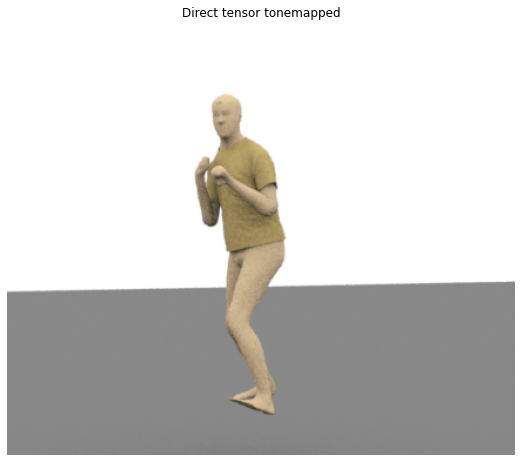

In [65]:
rendering_torch_tonemaped_np = rendering_torch_tonemaped.cpu().detach().numpy() 
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 2, 1)
ax.imshow(rendering_torch_tonemaped_np)
ax.axis('off')
ax.set_title('Direct tensor tonemapped')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Saved image')

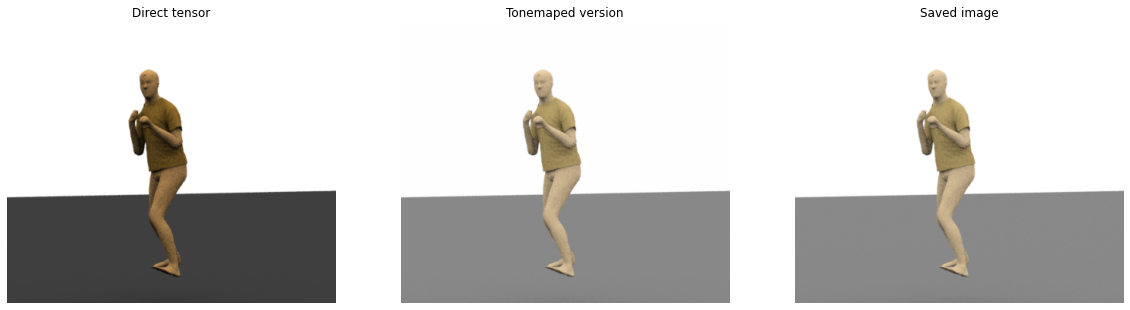

In [19]:

#canvas = rendering_torch_BGR.cpu().detach().numpy() 
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 3, 1)
ax.imshow(rendering_torch_raw)
ax.axis('off')
ax.set_title('Direct tensor')


ax = fig.add_subplot(1, 3, 2)
ax.imshow(tonemaped)
ax.axis('off')
ax.set_title('Tonemaped version')

tone_map_version = cv2.imread(origal_file_name)[..., (2,1,0)]
ax = fig.add_subplot(1, 3, 3)
ax.imshow(tone_map_version)
ax.axis('off')
ax.set_title('Saved image')